In [2]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords, reuters
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests, warnings, zipfile, nltk, re, os
warnings.filterwarnings('ignore')

1. Повнозв'язані нейронні мережі

In [3]:
# Завантаження датасету з першої лаби
response = requests.get('https://www.kaggle.com/api/v1/datasets/download/jayeshx19/morning-routine-dataset')
with open('morning-routine-dataset.zip', 'wb') as f:
    f.write(response.content)

df = pd.read_csv('morning-routine-dataset.zip')
dfClear = df.drop(columns=["Date", "Notes"])

# Кодування категоріальних ознак
df_numeric = dfClear.copy()
le = LabelEncoder()
categorical_columns = df_numeric.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if col != 'Mood':
        df_numeric[col] = le.fit_transform(df_numeric[col].astype(str))
df_numeric['Mood'] = le.fit_transform(df_numeric['Mood'])
X = df_numeric.drop('Mood', axis=1)
y = df_numeric['Mood']

# Нормалізація даних
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Розділення на тренувальну та тестову вибірку
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Побудова нейронної мережі
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(3, activation='softmax')
])

# Компіляція та навчання моделі
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)
history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
test_accuracy = accuracy_score(y_test, y_pred)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3539 - loss: 1.0809 - val_accuracy: 0.6944 - val_loss: 0.8650
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5907 - loss: 0.8822 - val_accuracy: 0.7569 - val_loss: 0.6307
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7721 - loss: 0.6373 - val_accuracy: 0.7986 - val_loss: 0.4506
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7410 - loss: 0.5342 - val_accuracy: 0.8611 - val_loss: 0.3591
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7735 - loss: 0.4918 - val_accuracy: 0.8681 - val_loss: 0.3038
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8534 - loss: 0.3610 - val_accuracy: 0.9167 - val_loss: 0.2542
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8618 - loss: 0.3376 - val_accuracy: 0.9097 - val_loss: 0.2325
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8496 - loss: 0.3287 - val_accuracy: 0.9097 - 

In [4]:

print(f"Точність моделі на тестовій вибірці: {test_accuracy:.4f}")
print("Детальний звіт класифікації:")
print(classification_report(y_test, y_pred))

Точність моделі на тестовій вибірці: 0.9556
Детальний звіт класифікації:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        63
           1       0.91      0.94      0.93        54
           2       0.95      0.95      0.95        63

    accuracy                           0.96       180
   macro avg       0.95      0.96      0.95       180
weighted avg       0.96      0.96      0.96       180



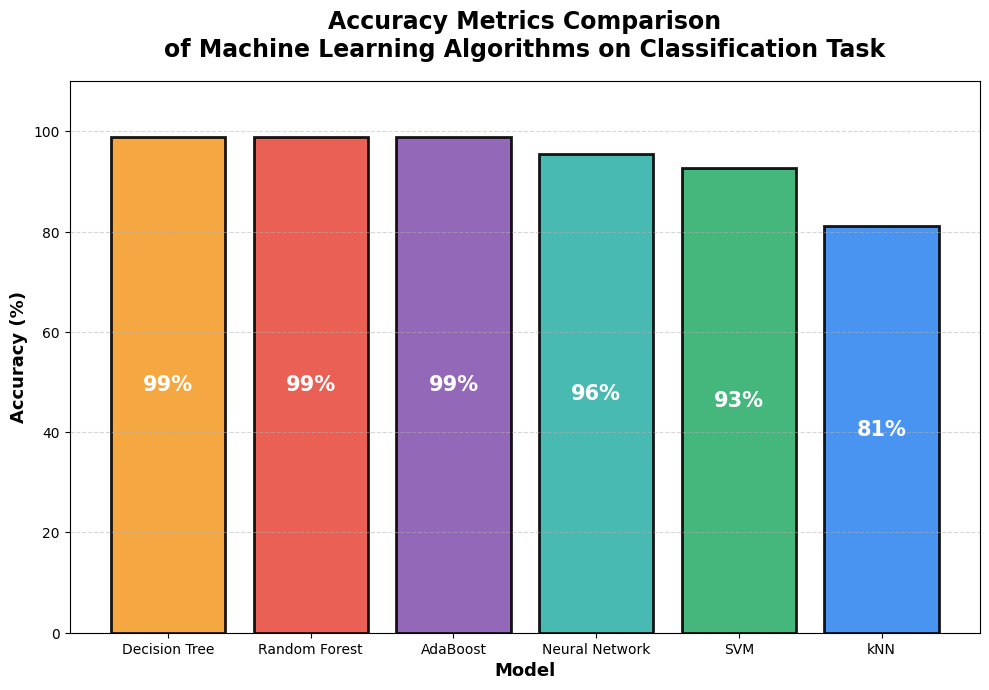

In [5]:
# Візуалізація поточного результату та результатів із першої лабораторної
all_results = {
    'kNN': 0.8111,
    'Decision Tree': 0.9889,
    'SVM': 0.9278,
    'Random Forest': 0.9889,
    'AdaBoost': 0.9889,
    'Neural Network': test_accuracy,
}

sorted_items = sorted(all_results.items(), key=lambda x: x[1], reverse=True)
labels = [x[0] for x in sorted_items]
values = [x[1] for x in sorted_items]

color_map = {
    'kNN': '#3489ef',
    'Decision Tree': '#f49e2d',
    'SVM': '#31af6e',
    'Random Forest': '#e94f41',
    'AdaBoost': '#8857b1',
    'Neural Network': '#34b3aa',
}
bar_colors = [color_map[x] for x in labels]
plt.figure(figsize=(10, 7))
bars = plt.bar(labels, [v*100 for v in values], color=bar_colors, edgecolor='black', alpha=0.90, linewidth=2)

for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height()/2,
        f"{value*100:.0f}%",
        ha='center', va='center',
        color='white',
        fontsize=15,
        fontweight='bold'
    )

plt.title('Accuracy Metrics Comparison\nof Machine Learning Algorithms on Classification Task', fontsize=17, fontweight='bold', y=1.03)
plt.xlabel('Model', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

2. Згорткові нейронні мережі

In [6]:
# Завантаження датасету
kaggle_url = 'https://www.kaggle.com/api/v1/datasets/download/divyansh22/dummy-astronomy-data'
data_dir = 'extract_dir/Cutout Files'
response = requests.get(kaggle_url, timeout=300, stream=True)
with open('dummy-astronomy-data.zip', 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)
with zipfile.ZipFile('dummy-astronomy-data.zip', 'r') as zip_ref:
    zip_ref.extractall('extract_dir')
classes = os.listdir(data_dir)
print(f"Кількість зображень кожного із класів датасету:\n")
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    if os.path.isdir(cls_path):
        count = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.fits'))])
        print(f"{cls}: {count} зображень")
print()

# Підготовка даних для моделі
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

steps_per_epoch = max(1, train_generator.samples // train_generator.batch_size)
validation_steps = max(1, validation_generator.samples // validation_generator.batch_size)

print(f"Тренувальних зображень: {train_generator.samples}")
print(f"Валідаційних зображень: {validation_generator.samples}")

Кількість зображень кожного із класів датасету:

star: 3044 зображень
galaxy: 942 зображень

Found 3190 images belonging to 2 classes.
Found 796 images belonging to 2 classes.
Тренувальних зображень: 3190
Валідаційних зображень: 796


a) Побудова простої згорткової нейронної мережі

In [7]:
# CNN
model_simple = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model_simple.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

history_simple = model_simple.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

test_accuracy_simple = model_simple.evaluate(validation_generator, verbose=0)[1]
print(f"Точність CNN: {test_accuracy_simple:.4f} ({test_accuracy_simple*100:.2f}%)")

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.6823 - loss: 1.2788 - val_accuracy: 0.7591 - val_loss: 4.5182 - learning_rate: 0.0010
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8125 - loss: 0.5427 - val_accuracy: 0.7708 - val_loss: 4.3191 - learning_rate: 0.0010
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7678 - loss: 0.5640 - val_accuracy: 0.7669 - val_loss: 7.2779 - learning_rate: 0.0010
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7812 - loss: 0.4895 - val_accuracy: 0.7604 - val_loss: 7.4709 - learning_rate: 0.0010
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.7648 - loss: 0.5468 - val_accuracy: 0.7630 - val_loss: 7.9659 - learning_rate: 0.0010
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7812 - loss: 0.4702 - val_accuracy: 0.7695 - val_loss: 7.7848 - learning_rate: 0.0010
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.7620 - loss: 0.5407 - val_a

б) Transfer learning (MobileNetV2)

In [8]:
# Transfer learning (MobileNetV2)
base_model = MobileNetV2(
    input_shape=(64, 64, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(64, 64, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model_transfer = Model(inputs, outputs)
model_transfer.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

history_transfer = model_transfer.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=40,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

test_accuracy_transfer = model_transfer.evaluate(validation_generator, verbose=0)[1]
print(f"Точність Transfer Learning: {test_accuracy_transfer:.4f} ({test_accuracy_transfer*100:.2f}%)")

# Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model_transfer.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=['accuracy']
)

history_finetune = model_transfer.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

test_accuracy_finetune = model_transfer.evaluate(validation_generator, verbose=0)[1]
print(f"Точність після Fine-tuning: {test_accuracy_finetune:.4f} ({test_accuracy_finetune*100:.2f}%)")



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 46s 296ms/step - accuracy: 0.6119 - loss: 1.1703 - val_accuracy: 0.7630 - val_loss: 0.5503 - learning_rate: 1.0000e-04
Epoch 2/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7188 - loss: 0.6281 - val_accuracy: 0.7630 - val_loss: 0.5489 - learning_rate: 1.0000e-04
Epoch 3/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 0.6799 - loss: 0.7122 - val_accuracy: 0.7643 - val_loss: 0.5447 - learning_rate: 1.0000e-04
Epoch 4/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.6562 - loss: 0.6714 - val_accuracy: 0.7643 - val_loss: 0.5417 - learning_rate: 1.0000e-04
Epoch 5/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.7225 - loss: 0.6112 - val_accuracy: 0.7695 - val_loss: 0.5474 - learning_rate: 1.0000e-04
Epoch 6/40
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5938 - loss: 0.6547 - val_accuracy: 0.7682 - val_loss: 0.5525 - learning_rate: 1.0000e-04
Epoch 7/40
99/99 

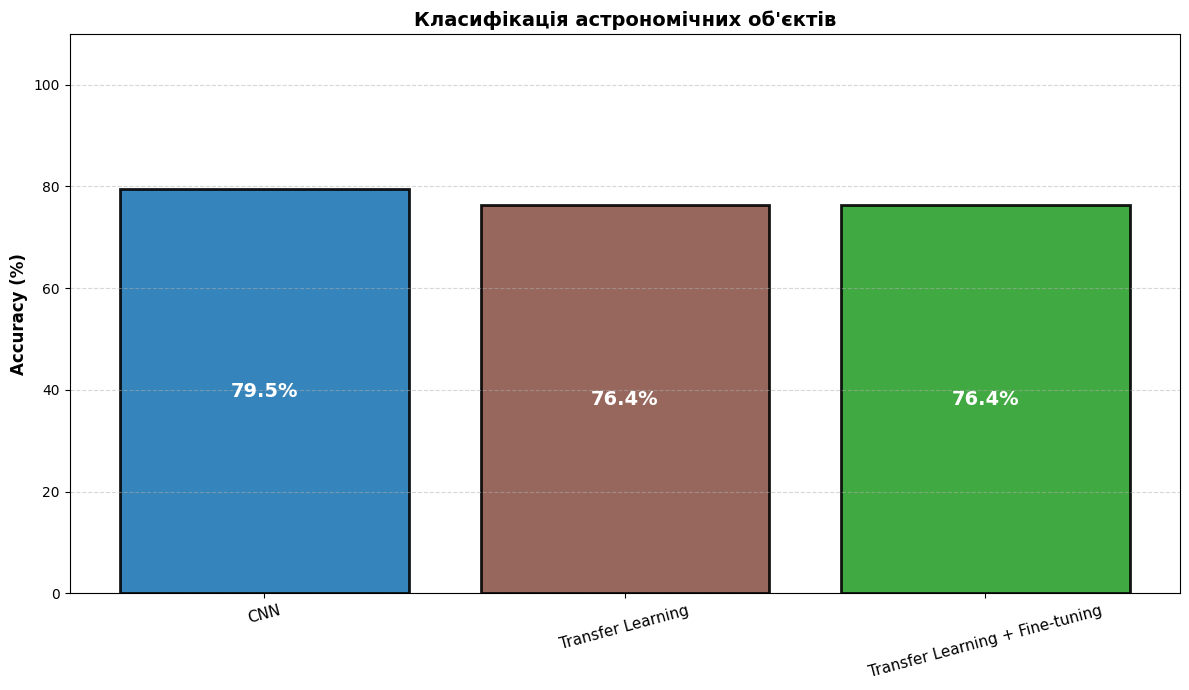

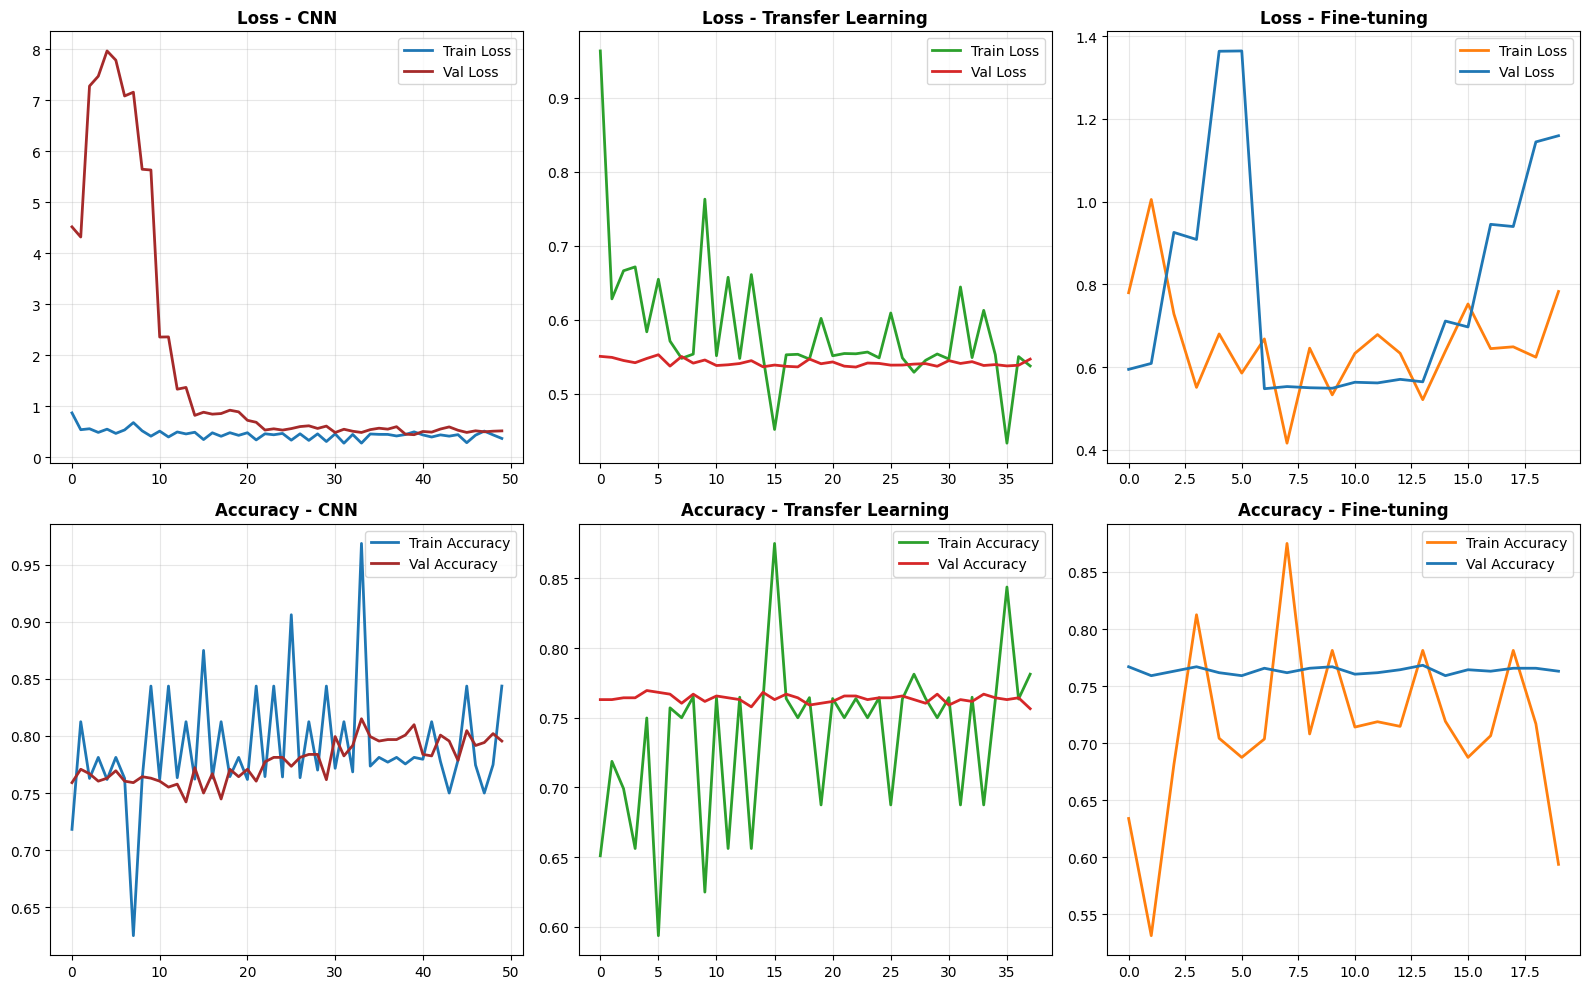

In [18]:
# Візуалізація результатів
comparison_results = {
    'CNN': test_accuracy_simple,
    'Transfer Learning': test_accuracy_transfer,
    'Transfer Learning + Fine-tuning': test_accuracy_finetune,
}

plt.figure(figsize=(12, 7))
sorted_results = dict(sorted(comparison_results.items(), key=lambda x: x[1], reverse=True))
colors = ['#1f77b4', '#8c564b', '#2ca02c']
bars = plt.bar(range(len(sorted_results)), [v*100 for v in sorted_results.values()],
               color=colors, edgecolor='black', alpha=0.90, linewidth=2)

for bar, value in zip(bars, sorted_results.values()):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height()/2,
        f"{value*100:.1f}%",
        ha='center', va='center',
        color='white', fontsize=14, fontweight='bold'
    )

plt.xticks(range(len(sorted_results)), sorted_results.keys(), fontsize=11, rotation=15)
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Класифікація астрономічних об\'єктів', fontsize=14, fontweight='bold')
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# CNN
axes[0, 0].plot(history_simple.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history_simple.history['val_loss'], label='Val Loss', linewidth=2, color='brown')
axes[0, 0].set_title('Loss - CNN', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[1, 0].plot(history_simple.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1, 0].plot(history_simple.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='brown')
axes[1, 0].set_title('Accuracy - CNN', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Transfer Learning
axes[0, 1].plot(history_transfer.history['loss'], label='Train Loss', linewidth=2, color='#2ca02c')
axes[0, 1].plot(history_transfer.history['val_loss'], label='Val Loss', linewidth=2, color='#d62728')
axes[0, 1].set_title('Loss - Transfer Learning', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 1].plot(history_transfer.history['accuracy'], label='Train Accuracy', linewidth=2, color='#2ca02c')
axes[1, 1].plot(history_transfer.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#d62728')
axes[1, 1].set_title('Accuracy - Transfer Learning', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Fine-tuning
axes[0, 2].plot(history_finetune.history['loss'], label='Train Loss', linewidth=2, color='#ff7f0e')
axes[0, 2].plot(history_finetune.history['val_loss'], label='Val Loss', linewidth=2, color='#1f77b4')
axes[0, 2].set_title('Loss - Fine-tuning', fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[1, 2].plot(history_finetune.history['accuracy'], label='Train Accuracy', linewidth=2, color='#ff7f0e')
axes[1, 2].plot(history_finetune.history['val_accuracy'], label='Val Accuracy', linewidth=2, color='#1f77b4')
axes[1, 2].set_title('Accuracy - Fine-tuning', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

3. Задача класифікації текстів

In [23]:
nltk.download('stopwords')
nltk.download('reuters')
def clean_text_simple(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()
    STOPWORDS = set(stopwords.words('english'))
    tokens = [t for t in text.split() if t not in STOPWORDS and len(t) > 2]
    return " ".join(tokens)


def load_reuters_earn_acq(max_docs_per_cat=None):
    selected = ['earn',  # статті про прибутки/доходи
                'acq']   # статті про злиття та поглинання компаній
    rows = []
    for fid in reuters.fileids():
        cats = reuters.categories(fid)
        common = [c for c in cats if c in selected]
        if common:
            rows.append((fid, reuters.raw(fid), common[0]))
    df = pd.DataFrame(rows, columns=['fileid', 'text', 'target_name'])
    if max_docs_per_cat is not None:
        df_list = []
        for cat, g in df.groupby('target_name'):
            df_list.append(g.sample(min(len(g), max_docs_per_cat), random_state=42))
        df = pd.concat(df_list).reset_index(drop=True)

    df['cleaned'] = df['text'].apply(clean_text_simple)
    df = df[df['cleaned'].str.len() > 50].reset_index(drop=True)
    df['target'] = pd.factorize(df['target_name'])[0]
    return df


# Завантаження та обробка даних Reuters
df_reuters = load_reuters_earn_acq(max_docs_per_cat=500)
texts = df_reuters['cleaned'].values
labels = df_reuters['target'].values
NUM_WORDS = 8000
MAX_LEN = 100
tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X_pad = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
y = labels
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.30, random_state=42, stratify=y)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


а) Random Embedding + Bidirectional LSTM

In [28]:
model1 = Sequential([
    Embedding(NUM_WORDS, 128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

history1 = model1.fit(
    X_train, y_train, epochs=10, batch_size=32,
    validation_split=0.2, callbacks=[early_stop, reduce_lr], verbose=1
)

y_pred1 = (model1.predict(X_test) > 0.5).astype(int).flatten()
acc1 = accuracy_score(y_test, y_pred1)
print(f"\nТочність Random Embedding: {acc1:.4f}")
print(classification_report(y_test, y_pred1, target_names=df_reuters['target_name'].unique()))

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5987 - loss: 0.6761 - val_accuracy: 0.9281 - val_loss: 0.3941 - learning_rate: 0.0010
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9325 - loss: 0.2994 - val_accuracy: 0.9784 - val_loss: 0.0983 - learning_rate: 0.0010
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9743 - loss: 0.0890 - val_accuracy: 0.9856 - val_loss: 0.0491 - learning_rate: 0.0010
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9996 - loss: 0.0207 - val_accuracy: 0.9928 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.9928 - val_loss: 0.0178 - learning_rate: 0.0010
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9928 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0014 - val_acc

б) Embedding (GloVe) + Bidirectional LSTM

In [32]:
glove_url = 'http://nlp.stanford.edu/data/glove.6B.zip'
glove_zip = 'glove6b.zip'
glove_dir = 'glove/'

if not os.path.exists(glove_dir):
    os.makedirs(glove_dir, exist_ok=True)
if not os.path.exists(os.path.join(glove_dir, 'glove.6B.100d.txt')):
    r = requests.get(glove_url)
    with open(glove_zip, 'wb') as f:
        f.write(r.content)
    with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
        zip_ref.extractall(glove_dir)
    os.remove(glove_zip)

embedding_index = {}
with open(os.path.join(glove_dir, 'glove.6B.100d.txt'), 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_dim = 100
embedding_matrix = np.random.normal(scale=0.6, size=(NUM_WORDS, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < NUM_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

model2 = Sequential([
    Embedding(NUM_WORDS, embedding_dim, input_length=MAX_LEN, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop2 = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr2 = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

history2 = model2.fit(
    X_train, y_train, epochs=10, batch_size=32,
    validation_split=0.2, callbacks=[early_stop2, reduce_lr2], verbose=1
)

y_pred2 = (model2.predict(X_test) > 0.5).astype(int).flatten()
acc2 = accuracy_score(y_test, y_pred2)
print(f"\nТочність Embedding (GloVe): {acc2:.4f}")
print(classification_report(y_test, y_pred2, target_names=df_reuters['target_name'].unique()))


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5982 - loss: 0.6667 - val_accuracy: 0.8705 - val_loss: 0.4690 - learning_rate: 0.0010
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8402 - loss: 0.4562 - val_accuracy: 0.9568 - val_loss: 0.1497 - learning_rate: 0.0010
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9253 - loss: 0.2562 - val_accuracy: 0.9784 - val_loss: 0.0788 - learning_rate: 0.0010
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9545 - loss: 0.1487 - val_accuracy: 0.9784 - val_loss: 0.0665 - learning_rate: 0.0010
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9551 - loss: 0.1590 - val_accuracy: 0.9712 - val_loss: 0.0874 - learning_rate: 0.0010
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9388 - loss: 0.1778 - val_accuracy: 0.9640 - val_loss: 0.0680 - learning_rate: 0.0010
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9792 - loss: 0.0984 - val_acc

Точність Random Embedding: 0.987
Точність GloVe Embedding:  0.973



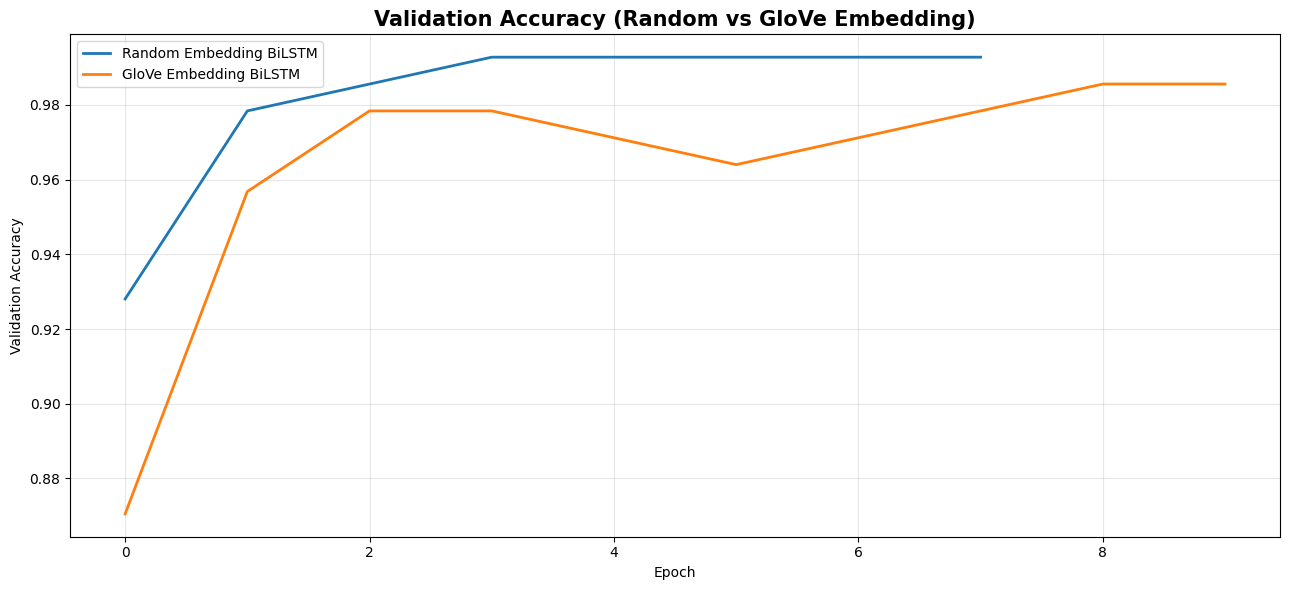

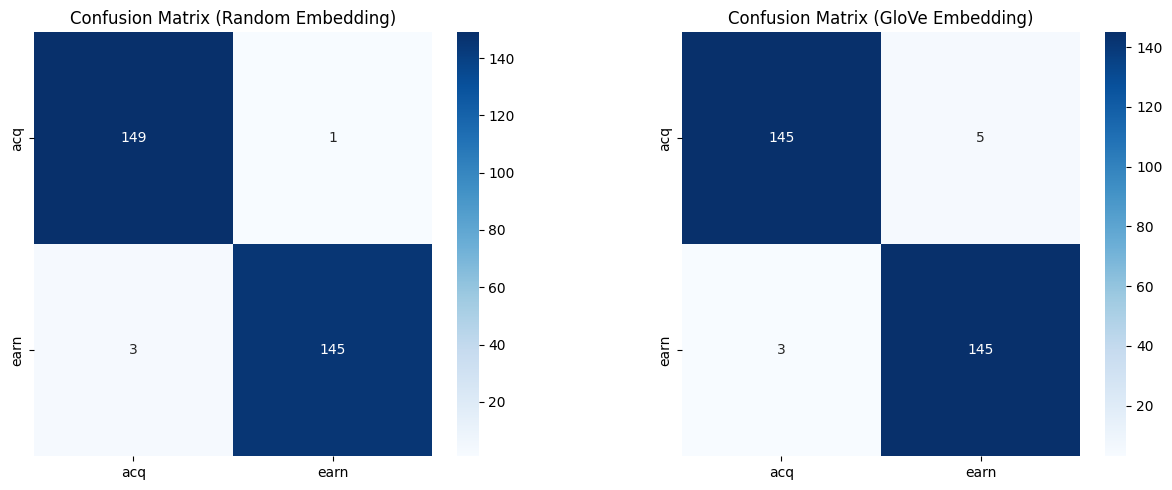

In [41]:
# Візуалізація результатів

print(f"Точність Random Embedding: {acc1:.3f}")
print(f"Точність GloVe Embedding:  {acc2:.3f}\n")

plt.figure(figsize=(13,6))
plt.plot(history1.history['val_accuracy'], label='Random Embedding BiLSTM', linewidth=2)
plt.plot(history2.history['val_accuracy'], label='GloVe Embedding BiLSTM', linewidth=2)
plt.title('Validation Accuracy (Random vs GloVe Embedding)', fontsize=15, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, (y_pred, label) in enumerate(zip([y_pred1, y_pred2], ["Random Embedding", "GloVe Embedding"])):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=df_reuters['target_name'].unique(),
                yticklabels=df_reuters['target_name'].unique(),
                ax=axes[i])
    axes[i].set_title(f'Confusion Matrix ({label})')
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.show()